In [ ]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import tensorflow as tf 

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [ ]:
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers import Adam, SGD

***                                                            Task 1) Upload DataSet in batches::***





In [ ]:
#Load the dataset in batches
#create dataset

batch_size = 1000000
img_height = 180
img_width = 180

data_dir = 'CustomImageDataset'

In [ ]:
def load_data(root_path, dir, batch_size, phase):
    transform_dict = {
        'src': transforms.Compose(
        [transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
         ]),
        'tar': transforms.Compose(
        [transforms.Resize(224),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
         ])}
    data = datasets.ImageFolder(root=root_path + dir, transform=transform_dict[phase])
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=4)
    return data_loader 

                                                       **2) Print Sample Image and Recontructed :: ** 




In [ ]:

x_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9766 files belonging to 96 classes.
Using 7813 files for training.


In [ ]:
x_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9766 files belonging to 96 classes.
Using 1953 files for validation.


In [ ]:
x_train = None

for image, label in tfds.as_numpy(x_train_ds):
  print(type(image), type(label), label, len(label))
  x_train = image
  print('------')

<class 'numpy.ndarray'> <class 'numpy.ndarray'> [54 48  8 ... 42 21  4] 7813
------


In [ ]:
x_test = None

for image, label in tfds.as_numpy(x_test_ds):
  print(type(image), type(label), label, len(label))
  x_test = image
  print('------')

<class 'numpy.ndarray'> <class 'numpy.ndarray'> [77 78 64 ... 84 79 72] 1953
------


In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [ ]:
test_pred_y = autoencoder.predict(x_test)

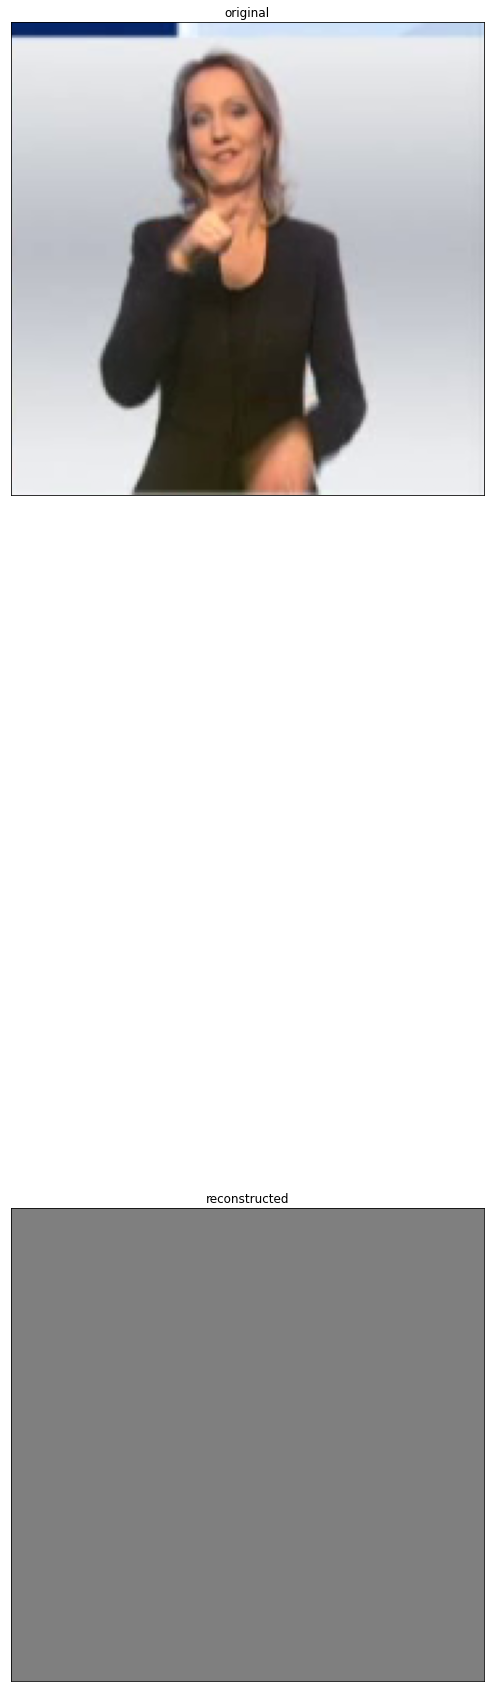

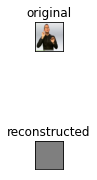

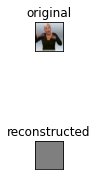

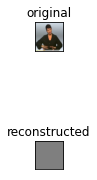

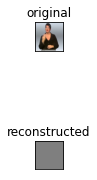

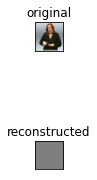

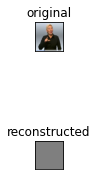

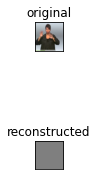

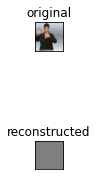

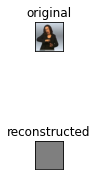

In [ ]:
n = 10
plt.figure(figsize=(100, 40))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(test_pred_y[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.show()

 **             3) Apply CNN through Encoder**

In [ ]:
## Hyperparameters
H = 180
W = 180
C = 3

## Latent space
latent_dim = 128

In [ ]:
## Building the encoder
inputs = layers.Input(shape=(H, W, C), name="inputs")
x = inputs

x = layers.Conv2D(32, (3,3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.MaxPool2D((2,2))(x)

x = layers.Conv2D(32, (3,3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.MaxPool2D((2,2))(x)

print('shape after encoder: ', x.shape)

x = layers.Flatten()(x)
units = x.shape[1]
x = layers.Dense(latent_dim, name="latent")(x)


## Building the decoder
x = layers.Dense(units)(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Reshape((45, 45, 32))(x)

x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)

x = layers.Conv2DTranspose(C, (3,3), strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("sigmoid", name="outputs")(x)

outputs = x


shape after encoder:  (None, 45, 45, 32)


In [ ]:
print(x.shape)


(None, 180, 180, 3)


In [ ]:
autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer=Adam(1e-3), loss='binary_crossentropy')
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_8 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 32)        9248

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=False,
                validation_data=(x_test, x_test))

Epoch 1/1000
